In [96]:
%cd ~/WGL_project/LSST_forecast_code/

from importlib import reload
import CM_code.spurious_george as sp
reload(sp)

import numpy as np
import matplotlib.pyplot as plt
import scipy
import pyccl as ccl

/home/b7009348/WGL_project/LSST_forecast_code


In [14]:
# get xi_ls data to start playing around with bits of boost function
xi_ls, rp, Pi, z_Pi, z_l, dndz_l = sp.get_xi_ls()

Pk_gg calculated
xi_gg calculated
Order preserved for zl indices 0-299
xi_ls estimation complete


#### This next block should be the part that finds the photometric probability gaussian

In [47]:
# start by constructing dndz_Pi using SRD parameterisation
z_Pi_norm = [0] * len(z_l)
dndz_Pi = [0] * len(z_l)
dndz_Pi_norm = [0] * len(z_l)
zph_norm = [0] * len(z_l)

z0 = sp.zed.y1_z0_source
alpha = sp.zed.y1_alp_source

z_s, dndz_s, zseff = sp.zed.get_dndz_spec('source', year=1.)

for zi in range(len(z_l)):
    # un-normalised
    dndz_Pi[zi] = z_Pi[zi]**2 * np.exp(-(z_Pi[zi]/z0) ** alpha)

    # dist and redshifts for normalisation
    z_Pi_norm[zi] = np.linspace(0., np.max(z_s)+0.5, len(z_Pi[zi]))
    dndz_Pi_norm[zi] = z_Pi_norm[zi]**2 * np.exp(-(z_Pi_norm[zi]/z0) ** alpha)

    dndz_Pi_norm[zi] = dndz_Pi_norm[zi] / scipy.integrate.simps(dndz_Pi_norm[zi], z_Pi_norm[zi]) 

    # set full range of photo-z to normalise over
    zph_norm[zi] = np.linspace(0., np.max(z_s)+0.5, len(z_Pi[zi]))

# next get error dist p_zPi_zph
p_zPi_zph = [0] * len(z_l)
p_zPi_zph_norm = [0] * len(z_l)

# first loop over z_Pi values for each lens redshift
for zl in range(len(z_l)):

    # define photo-z shift value for each zl
    chi_plus = ccl.comoving_radial_distance(sp.zed.cosmo_SRD, 
                                        1./(1. + np.max(z_Pi[zl]))) * (sp.pa.HH0/100.) + np.max(Pi[zl])
    a_plus = ccl.scale_factor_of_chi(sp.zed.cosmo_SRD, chi_plus / (sp.pa.HH0/100.))
    zph_plus = (1. / a_plus) - 1.
    # set arbitrary photo-z values in range of z_Pi boosted by 200Mpc in z                                 
    zPi_ph = np.linspace(np.min(z_Pi[zl]), zph_plus, len(z_Pi[zl]))

    # variance for each z_Pi
    sig_z = 0.05*(1. + z_Pi[zl])
    sig_z_norm = 0.05*(1. + z_Pi_norm[zl])

    p = np.zeros([len(zPi_ph), len(z_Pi[zl])])
    p_norm = np.zeros([len(zPi_ph), len(z_Pi[zl])])

    # loop over specific z_Pi values to find error dist for each z_Pi, 
    # also include normalisation over full redshift range
    for zi in range(len(z_Pi[zl])):
        # create 2D array of z_ph probability at each z_Pi
        p[zi,:] =  1. / (np.sqrt(2. * np.pi) * sig_z) * np.exp(-((zPi_ph - z_Pi[zl][zi])**2) / (2. * sig_z**2))

        p_norm[zi,:] =  1. / (np.sqrt(2. * np.pi) * sig_z_norm) * np.exp(-((zph_norm[zl] - z_Pi_norm[zl][zi])**2) / (2. * sig_z_norm**2))

    # save p(z_Pi,z_ph) at each lens redshift
    p_zPi_zph[zl] = p
    # need to also get error pdf for full zph to normalise over
    p_zPi_zph_norm[zl] = p_norm

#### Convolve photo-z probability with redshift distribution

3.96237611587694e-24


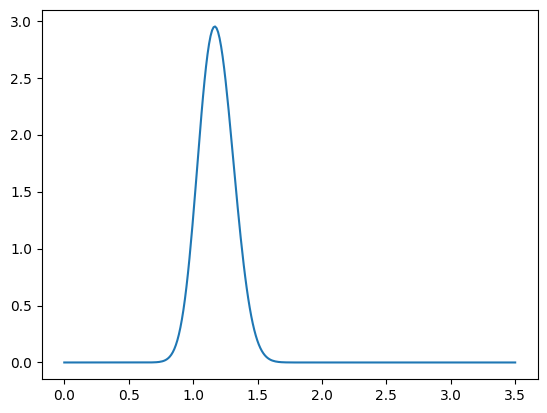

In [75]:
lensZ = sp.zed.get_dndz_phot(gtype='source',
                      zsmin=np.min(z_Pi[4]),
                      zsmax=np.max(z_Pi[4])
                     )

plt.plot(lensZ[0], lensZ[1])
print(lensZ[1][0])

In [ ]:
# lets try test boosts and see what we get
boost, theta = sp.test_boosts()

Pk_gg calculated
